<center> <h1>LangGraph x MCP - Web Search Tool</h1>

In [ ]:
%pip install --upgrade langchain-mcp-adapters

#### 1. Bedrock Model

In [1]:
import yaml

with open('../secrets.yml', 'r') as file:
    credentials = yaml.safe_load(file)

In [2]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-sonnet-20240620-v1:0",
    region_name="us-east-1",
    aws_access_key_id=credentials["bedrock"]["access_key"],
    aws_secret_access_key=credentials["bedrock"]["secret_key"]
)

#### 2. MCP Server Setup

Terminal command using npx and supergateway :
```bash
    npx -y supergateway \
    --stdio "npx -y tavily-mcp@0.1.3" \
    --outputTransport streamableHttp \
    --port 8000
```

#### 3. MCP Client Setup

In [3]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "toolbox": {
            "url": f"http://localhost:8000/mcp",
            "transport": "streamable_http",
        }
    }
)

Check the tools exposed by the server :

In [ ]:
tools = await client.get_tools()
tools

[StructuredTool(name='tavily-search', description="A powerful web search tool that provides comprehensive, real-time results using Tavily's AI search engine. Returns relevant web content with customizable parameters for result count, content type, and domain filtering. Ideal for gathering current information, news, and detailed web content analysis.", args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': 'Search query'}, 'search_depth': {'type': 'string', 'enum': ['basic', 'advanced'], 'description': "The depth of the search. It can be 'basic' or 'advanced'", 'default': 'basic'}, 'topic': {'type': 'string', 'enum': ['general', 'news'], 'description': 'The category of the search. This will determine which of our agents will be used for the search', 'default': 'general'}, 'days': {'type': 'number', 'description': "The number of days back from the current date to include in the search results. This specifies the time frame of data to be retrieved. Please

In [25]:
import json
print(json.dumps(tools[0].args_schema, indent=4))

{
    "type": "object",
    "properties": {
        "query": {
            "type": "string",
            "description": "Search query"
        },
        "search_depth": {
            "type": "string",
            "enum": [
                "basic",
                "advanced"
            ],
            "description": "The depth of the search. It can be 'basic' or 'advanced'",
            "default": "basic"
        },
        "topic": {
            "type": "string",
            "enum": [
                "general",
                "news"
            ],
            "description": "The category of the search. This will determine which of our agents will be used for the search",
            "default": "general"
        },
        "days": {
            "type": "number",
            "description": "The number of days back from the current date to include in the search results. This specifies the time frame of data to be retrieved. Please note that this feature is only available when using the 

#### 4. AI Agent (LangGraph)

In [13]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(llm, tools)

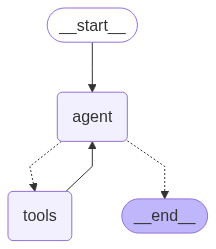

In [14]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [10]:
async def run_agent(agent, query):
    async for event in agent.astream(
        {"messages": [{"role": "user", "content": query}]},
        stream_mode="values",
    ):
        event["messages"][-1].pretty_print()

#### 5. Test

In [ ]:
await run_agent(agent, "What is the A2A protocol in AI and how does it work?")

================================ Human Message =================================

What is the A2A protocol in AI and how does it work?
================================== Ai Message ==================================
Tool Calls:
  tavily-search (toolu_bdrk_011tmzYJ3GbqRNV5h7XhAT8Y)
 Call ID: toolu_bdrk_011tmzYJ3GbqRNV5h7XhAT8Y
  Args:
    query: A2A protocol in AI: definition and how it works
    search_depth: advanced
================================= Tool Message =================================
Name: tavily-search

Detailed Results:

Title: Agent2Agent (A2A) Protocol Explained: Improving Multi- ...
URL: https://www.altexsoft.com/blog/a2a-protocol-explained/
Content: The Agent2Agent (A2A) protocol is a communication standard designed to help AI agents work together no matter their vendor or underlying model. Developed by Google in 2025, A2A lays out a clear structure for how agents should coordinate actions without relying on custom code for each interaction. [...] In the A2A protoco